## Imports

In [3]:
import cv2
import functools
from IPython.display import Markdown, clear_output, display, HTML
from ipywidgets import widgets, Layout,Label, HBox, VBox, Box
import matplotlib.pyplot as plt
import numpy as np
from os import path
from os import listdir
from os.path import isfile, join
from skimage.filters import gaussian, threshold_li, sato, threshold_otsu
from skimage import img_as_float, img_as_ubyte
from skimage.color import rgb2hsv,rgb2gray
import skimage.morphology as mp
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, train_test_split, KFold, cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import sys

from dataclasses import dataclass, field, InitVar
from typing import List

## Class used for reading images from file

In [4]:
@dataclass
class ImageReader:
    _img: List[int] = field(default_factory = list)
    _expected: List[int] = field(default_factory = list)
    _mask: List[int] = field(default_factory = list)
    
    def upload_image(self, filepath: str, maskfilepath):
        self.img = cv2.imread("img/" + filepath)
        self.expected = cv2.imread("img/expected/" + filepath)
        self.mask = cv2.imread("img/mask/" + maskfilepath)
    
    def show_picture(self, title: str = ""):
        img1 = cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB)
        fig = plt.figure(figsize=(6,6))
        plt.title(f"Upload image: {title}", fontsize = 16)
        sub = fig.add_subplot(111)
        plt.axis('off')
        plt.imshow(img1, cmap = "gray") 
    
    def show_everycolor_channel(self):
        img1 = cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(20,10))
        
        plt.subplot(141)
        plt.imshow(img1, cmap = "gray")
        plt.title("Orginal image")
        plt.axis('off')
        
        plt.subplot(142)
        plt.imshow(img1[:, :, 0], cmap = "gray")
        plt.title("Blue channel")
        plt.axis('off')
        
        plt.subplot(143)
        plt.imshow(img1[:, :, 1], cmap = "gray")
        plt.title("Green channel")
        plt.axis('off')
        
        plt.subplot(144)
        plt.imshow(img1[:, :, 2], cmap = "gray")
        plt.title("Red channel")
        plt.axis('off')
    
    @property
    def img(self):
        return self._img

    @img.setter
    def img(self, value):
        self._img = value
    
    @property
    def expected(self):
        return self._expected
    
    @expected.setter
    def expected(self, value):
        self._expected = value
    
    @property
    def mask(self):
        return self._mask
    
    @mask.setter
    def mask(self, value):
        self._mask = value


## Class used for manual processing

In [5]:
%matplotlib inline
@dataclass
class BasicProcessing:
    _image_object: ImageReader = ImageReader()
    _result_image: List[int] = field(default_factory = list)
    
    def find_fundus(self):
        img_orig = self.image_object.img.copy()
        img_normalization_color_image = self.normalization_color_image(img_orig[:, :, 1]) 
        img_sato = self.extract_vessels(img_normalization_color_image)
        img_manual = self.normalization_manual(img_sato)
        img_morphological = self.morphological_iltering(img_manual)
        img_thresh = self.thresh(img_morphological)
        img_final = self.final_processing(img_thresh)
        self.result_image = img_final
   
    
    def normalization_color_image(self, img: List[int] = field(default_factory = list)):
#         Normalizacja histogramu kolorów
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        img_clahe = clahe.apply(img)
        
        return img_clahe
    
    def extract_vessels(self, img: List[int] = field(default_factory = list)):
#         Filter an image with the Sato tubeness filter.
#         This filter can be used to detect continuous ridges, 
#         e.g. tubes, wrinkles, rivers. It can be used to calculate 
#         the fraction of the whole image containing such objects.
#         filtr Sato: wykrywa żyłki
        img_sato = sato(img)
    
        return img_sato
    
    def normalization_manual(self, img: List[int] = field(default_factory = list)):
#         Normalizacja obrazu
        img_manual_normalization = (img - np.min(img)) / (np.max(img) - np.min(img))
    
        return img_manual_normalization
    
    
    def morphological_iltering(self, img: List[int] = field(default_factory = list)):
#         https://scikit-image.org/docs/dev/auto_examples/applications/plot_morphology.html
#         Operacje morfologiczne są jednymi z ważniejszych operacji przetwarzania obrazów, 
#         gdyż pozwalają przeprowadzić zaawansowaną analizę kształtów poszczególnych obiektów 
#         oraz odległości między nimi. Podstawowe przekształcenia morfologiczne można ze sobą łączyć, 
#         co daje podstawę do budowania skomplikowanych systemów analizy obrazu.

#         morfologiczne poszerzenie obrazu
#         poszerza obszał w koły żył
        img_dilation = mp.dilation(img, selem = mp.disk(6))
#         Rozmycie gaussowskie
        img_gaussian = gaussian(img_dilation, sigma = 3)
#         laczy ze soba "uwrwane" fragmenty
        img_closing = mp.closing(img_gaussian, selem = mp.disk(8))
        img = mp.erosion(img,selem = mp.disk(2))
        
        return img_closing
    
    def thresh(self, img: List[int] = field(default_factory = list)):
        thresh = threshold_otsu(img)
        img_thresh = img > thresh
        
        return img_thresh
    
    def final_processing(self, img: List[int] = field(default_factory = list)):
#         Nołożenie maski na wynik
        mask = img_as_float(rgb2gray(self.image_object.mask))
        mask = mp.erosion(mask, selem = mp.disk(5))
        img_with_mask = img * mask
        
        img_values_to_255 = img_with_mask * 255
        
        return img_values_to_255

        
    def statistic(self):
        TP = TN = FP = FN = all_pixels = 0
        for x in range(self.result_image.shape[1]):
            for y in range(self.result_image.shape[0]):
                if self.image_object.mask[:, :, 1].item(y,x) == 255:
                    all_pixels += 1
                    if self.image_object.expected[:, :, 1].item(y, x) == 255 and self.result_image.item(y, x) == 255:
                        TP += 1
                    if self.image_object.expected[:, :, 1].item(y,x) == 0 and self.result_image.item(y,x) == 0:
                        TN += 1
                    if self.image_object.expected[:, :, 1].item(y,x) == 0 and self.result_image.item(y,x) == 255:
                        FP += 1
                    if self.image_object.expected[:, :, 1].item(y,x) == 255 and self.result_image.item(y,x) == 0:
                        FN += 1

        accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
        sensitivity = (TP / float(TP + FN))
        specificity = (TN / float(TN + FP))
        geo_mean_val = (sensitivity * specificity)**(1.0/2)

        return (accuracy, sensitivity, specificity, geo_mean_val)
    
#     Wizualizacja
    def end_of_processing(self, name):
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,16))
        plt.sca(ax[0])
        plt.axis('off')
        plt.imshow(self.result_image, cmap = "gray")
        plt.title("Changed image")
        plt.sca(ax[1])
        plt.axis('off')
        plt.imshow(self.image_object.expected, cmap = "gray")
        plt.title("Expected")
        plt.sca(ax[2])
        plt.axis('off')
        plt.imshow(self.image_object.img[:, :, 1], cmap = "gray")
        plt.title("Orginal image")

        plt.show()
        
    def picture_compare(self, img: List[int] = field(default_factory = list), title: str = ""):
        plt.figure(figsize=(20,10))
        
        plt.subplot(121)
        plt.imshow(self.image_object.img[:, :, 1], cmap = "gray")
        plt.title("Orginal image")
        plt.axis('off')
        
        plt.subplot(122)
        plt.imshow(img, cmap = "gray")
        plt.title(title)
        plt.axis('off')

    
    @property
    def image_object(self):
        return self._image_object 
    @image_object.setter
    def image_object(self, value):
        self._image_object = value
    
    @property
    def result_image(self):
        return self._result_image
    @result_image.setter
    def result_image(self, value: List[int] = field(default_factory = list)):
        self._result_image = value

## Objects

In [11]:
# c = ImageReader()
# name = "Image_14R.jpg"
# c.upload_image(name, "small.jpg")
# c.show_picture(name)
# c.show_everycolor_channel()
# f = BasicProcessing(c)
# f.find_fundus()
# f.end_of_processing(name)
# print("Accuracy: %f \nSensitivity: %f \nSpecificity: %f \nGeo mean metric: %f\n"%f.statistic())

## Class used for basic classification model

In [1]:
from skimage import io, filters, exposure, feature
from skimage.morphology import dilation, erosion, convex_hull_image
from skimage.measure import moments_central, moments_normalized, moments_hu
from skimage import img_as_float
from skimage.color import rgb2gray
import numpy as np
import os
import random
import warnings
warnings.simplefilter("ignore")
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, train_test_split, KFold, cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import sys
import time

@dataclass
class ImageLearning:
    _learing_array: List[int] = field(default_factory = list)
    _size: int = 5
    _amount: int = 150
    _result_image: List[int] = field(default_factory = list)
    _result_mask: List[int] = field(default_factory = list)
    _result_expected: List[int] = field(default_factory = list)
    
    def preprocess(self, img):
        img = filters.gaussian(img, sigma = 0.4)
        img = exposure.equalize_adapthist(img, clip_limit=0.03)

        return img
    
    def get_hu(self, img, half, x, y):
        mu = moments_central(
            img[x - half : x + self.size - half, 
                y - half : y + self.size - half]
        )
        nu = moments_normalized(mu)
        hu = moments_hu(nu)  
        return hu
    
    def random_x_y(self, img, half):
        x, y = img.shape
        x_return = random.randint(
            half, 
            x - self.size + half
        )
        y_return = random.randint(
            half, 
            y - self.size + half
        )
        
        return x_return, y_return

    def part_img(self, arr = ['Image_03R.jpg', 'Image_04L.jpg', 'Image_04R.jpg', 'Image_05L.jpg', 'Image_05R.jpg', 'Image_06L.jpg', 'Image_06R.jpg', 'Image_07L.jpg', 'Image_07R.jpg', 'Image_08L.jpg', 'Image_08R.jpg', 'Image_09L.jpg', 'Image_09R.jpg', 'Image_10L.jpg', 'Image_10R.jpg', 'Image_11L.jpg', 'Image_11R.jpg', 'Image_12L.jpg', 'Image_12R.jpg', 'Image_13L.jpg', 'Image_13R.jpg', 'Image_14L.jpg', 'Image_14R.jpg']):
        self.learing_array  = arr
        half = self.size//2
        images = self.learing_array
        momentsPos = []
        momentsNeg = []
        for img in images:
            
            image_reader = ImageReader()
            image_reader.upload_image(img, "small.jpg")
            expected = img_as_float(rgb2gray(image_reader.expected))
            mask = image_reader.mask[:, :, 0]/255
            img_pre = img_as_float(rgb2gray(image_reader.img))
            img_pre = self.preprocess(img_pre)

            momentPos = []
            momentNeg = []
            imoPos = []
            imoNeg = []
            while len(momentPos) < self.amount/2 or len(momentNeg) < self.amount/2:
                x = random.randint(half, len(img_pre)-self.size+half)
                y = random.randint(half, len(img_pre[0])-self.size+half)
                if mask[x][y] == 1:
                    if expected[x][y] == 1:
                        if len(momentPos) < self.amount/2:
                            imo = img_pre[x - half : x + self.size - half, 
                                    y - half : y + self.size - half]
                            mu = moments_central(
                                imo
                            )
                            nu = moments_normalized(mu)
                            hu = moments_hu(nu)   
                            o = np.array([*hu, *imo.flatten()])
                            momentPos.append(o)
                    else:
                        if len(momentNeg) < self.amount/2:
                            imo = img_pre[x - half : x + self.size - half, 
                                    y - half : y + self.size - half]
                            mu = moments_central(
                                imo
                            )
                            nu = moments_normalized(mu)
                            hu = moments_hu(nu)  
                            o = np.array([*hu, *imo.flatten()])
                            momentNeg.append(o)
            momentsPos += momentPos
            momentsNeg += momentNeg
        info = np.ones(len(momentsPos) + len(momentsNeg))
        info[len(momentsPos):] = 0
        allMom = momentsPos + momentsNeg
        return info, allMom
    
    def model(self, X, y, k = 10):
        X_train, X_test, y_train, y_test = train_test_split(
            X,
            y,
            test_size=0.2,
            shuffle=True,
            random_state=42,
        )
        model = KNeighborsClassifier(n_neighbors = 15)
        model.fit(X_train, y_train)
        acc = model.score(X_test, y_test)
        print("[INFO] histogram accuracy: {:.2f}%".format(acc * 100))
        return model
    
    def image_model(self, model, name: str = "Image_01L.jpg"):
        half = self.size//2
        o = ImageReader()
        o.upload_image(name, "small.jpg")
        mask = o.mask[:, :, 0]/255
        expected = img_as_float(rgb2gray(o.expected))
        img_pre = img_as_float(rgb2gray(o.img))
        img_pre = self.preprocess(img_pre)

        predicted = np.zeros((len(img_pre), len(img_pre[0])))
        start_time = time.time()
        for x in range(half, len(img_pre) - self.size + half):
            sys.stdout.write(str(x) + " / " + str(len(img_pre) - self.size + half - 1)+ ' ' + 'Time: ' + str(round((time.time() - start_time), 2)) + '\r')
            sys.stdout.flush()
            tmp = []
            for y in range(half, len(img_pre[0]) - self.size + half):
                if mask[x][y] == 1:
                    imo = img_pre[x - half : x + self.size - half, 
                            y - half : y + self.size - half]
                    mu = moments_central(
                        imo
                    )
                    nu = moments_normalized(mu)
                    hu = moments_hu(nu)  
                    flat = np.array([*hu, *imo.flatten()])
                    tmp.append(flat)
            if len(tmp) != 0:
                pred = model.predict(tmp)
                licz = 0
                for y in range(half, len(img_pre[0]) - self.size + half):
                    if mask[x][y] == 1:
                        predicted[x][y] = pred[licz]
                        licz += 1
                        
        plt.figure(figsize=(20,10))
        
        plt.subplot(131)
        plt.imshow(predicted, cmap = "gray")
        plt.title("Predicted")
        plt.axis('off')
        
        plt.subplot(132)
        plt.imshow(expected, cmap = "gray")
        plt.title("Expected")
        plt.axis('off')
        
        plt.subplot(133)
        plt.imshow(o.img[:, :, 1], cmap = "gray")
        plt.title("Orginal image")
        plt.axis('off')
        
        
        self.result_image = predicted
        self.result_mask = mask
        self.result_expected = expected
        
    def statistic(self):
        TP = TN = FP = FN = all_pixels = 0
        sh = self.result_image.shape
        for x in range(sh[0]):
            for y in range(sh[1]):
                if self.result_mask[x][y] == 1:
                    all_pixels += 1
                    if self.result_expected[x][y] == 1 and self.result_image[x][y] == 1:
                        TP += 1
                    if self.result_expected[x][y] == 0 and self.result_image[x][y] == 0:
                        TN += 1
                    if self.result_expected[x][y] == 0 and self.result_image[x][y] == 1:
                        FP += 1
                    if self.result_expected[x][y] == 1 and self.result_image[x][y] == 0:
                        FN += 1

        accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
        sensitivity = (TP / float(TP + FN))
        specificity = (TN / float(TN + FP))
        geo_mean_val = (sensitivity * specificity)**(1.0/2)

        return (accuracy, sensitivity, specificity, geo_mean_val)
    
    @property
    def learing_array(self):
        return self._learing_array
    @learing_array.setter
    def learing_array(self, value):
        self._learing_array = value
    
    @property
    def size(self):
        return self._size
    @size.setter
    def size(self, value):
        self._size = value
    
    @property
    def amount(self):
        return self._amount
    @amount.setter
    def amount(self, value):
        self._amount = value
        
    @property
    def result_image(self):
        return self._result_image
    @result_image.setter
    def result_image(self, value):
        self._result_image = value
        
    @property
    def result_mask(self):
        return self._result_mask
    @result_mask.setter
    def result_mask(self, value):
        self._result_mask = value
        
    @property
    def result_expected(self):
        return self._result_expected
    @result_expected.setter
    def result_expected(self, value):
        self._result_expected = value


NameError: name 'dataclass' is not defined

## Objects

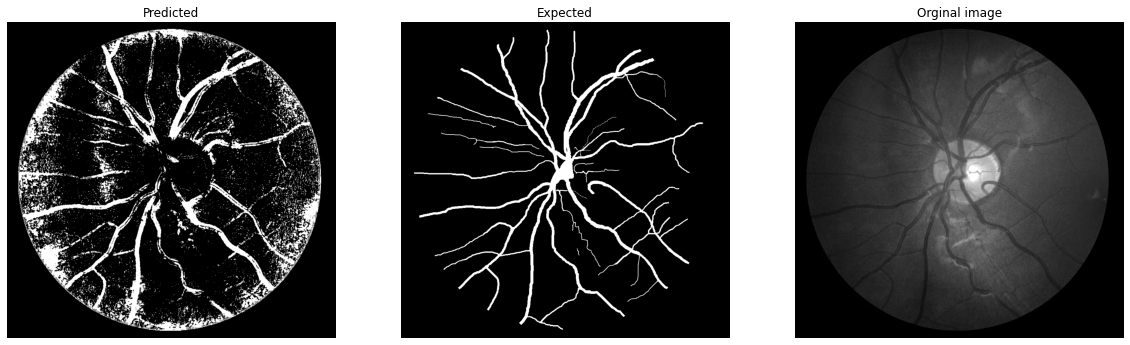

In [57]:
# d = ImageLearning()
# x = d.partImg()
# model = d.model5(x[1], x[0])
# d.imageModel(model, "Image_01L.jpg")
# print("Accuracy: %f \nSensitivity: %f \nSpecificity: %f \nGeo mean metric: %f\n"%d.statistic())

## Class used for deep learning

### disclamer
Inspared by https://medium.com/analytics-vidhya/humans-image-segmentation-with-unet-using-tensorflow-keras-fd6cb43b06e5

In [203]:
import cv2, os
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 15)
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Activation, Lambda, GlobalAveragePooling2D, concatenate
from tensorflow.keras.layers import UpSampling2D, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import pickle
import random
from sklearn.model_selection import train_test_split

@dataclass
class DeepLearning:
    
    _IMG_HEIGHT: int = 400
    _IMG_WIDTH: int = 400
    _epochs: int = 50
    _batch_size: int = 4
    _imgs_dir: str = "img/train/imgs/"
    _expec_dir: str = "img/train/expec/"
    _list_of_X_y: List[int] = field(default_factory = list)
    _image_object: ImageReader = ImageReader()
        
    def init(self):
        f = open("models2/HEIGHT_WIDTH.txt", "w")
        f.write(str(self.IMG_HEIGHT) + "\n" + str(self.IMG_WIDTH))
        f.close()
        print("[LOG] train_test_split...")
        self.list_of_X_y = self.split_train_test()
        print("[LOG] create_model...")
        model = self.create_model()
        print("[LOG] train_model...")
        self.train_model(model)
          
        
    def split_train_test(self):
        X = os.listdir(self.imgs_dir)
        y = os.listdir(self.expec_dir)

        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=1)

        X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.15, random_state=1)

        return X_train, y_train, X_val, y_val, X_test, y_test
        
    def keras_generator_train_val_test(self, choice: str = "train"):
        if choice == "train":
            X = self.list_of_X_y[0]
            y = self.list_of_X_y[1]
        elif choice == "val":
            X = self.list_of_X_y[2]
            y = self.list_of_X_y[3]
        elif choice == "test":
            X = self.list_of_X_y[4]
            y = self.list_of_X_y[5]
        else:
            print("Invalid Option")
            return False

        while True:
            x_batch = []
            y_batch = []

            for i in range(self.batch_size):
                x_rand = random.choice(X)
                y_rand = x_rand

                x_path = f"img/train/imgs/{x_rand}"
                y_path = f"img/train/expec/{y_rand}"

                x = cv2.imread(x_path)
                x = cv2.resize(x, (self.IMG_HEIGHT, self.IMG_WIDTH), interpolation = cv2.INTER_AREA)
                y = cv2.imread(y_path)
                y = cv2.resize(y, (self.IMG_HEIGHT, self.IMG_WIDTH), interpolation = cv2.INTER_AREA)

                x = x / 255.
                y = y / 255.

                x_batch.append(x)
                y_batch.append(y)


            x_batch = np.array(x_batch)
            # y_batch = np.array(y_batch)

            y_batch = {'seg': np.array(y_batch),
                    #    'cls': np.array(classification_list)
                    }

            yield x_batch, y_batch
            
    def create_model(self):
        in1 = Input(shape=(self.IMG_HEIGHT, self.IMG_WIDTH, 3 ))

        conv1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(in1)
        conv1 = Dropout(0.2)(conv1)
        conv1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv1)
        pool1 = MaxPooling2D((2, 2))(conv1)

        conv2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool1)
        conv2 = Dropout(0.2)(conv2)
        conv2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv2)
        pool2 = MaxPooling2D((2, 2))(conv2)

        conv3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool2)
        conv3 = Dropout(0.2)(conv3)
        conv3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv3)
        pool3 = MaxPooling2D((2, 2))(conv3)

        conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool3)
        conv4 = Dropout(0.2)(conv4)
        conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv4)

        up1 = concatenate([UpSampling2D((2, 2))(conv4), conv3], axis=-1)
        conv5 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up1)
        conv5 = Dropout(0.2)(conv5)
        conv5 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv5)

        up2 = concatenate([UpSampling2D((2, 2))(conv5), conv2], axis=-1)
        conv6 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up2)
        conv6 = Dropout(0.2)(conv6)
        conv6 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv6)

        up2 = concatenate([UpSampling2D((2, 2))(conv6), conv1], axis=-1)
        conv7 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up2)
        conv7 = Dropout(0.2)(conv7)
        conv7 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv7)
        segmentation = Conv2D(3, (1, 1), activation='sigmoid', name='seg')(conv7)

        model = Model(inputs=[in1], outputs=[segmentation])

        losses = {'seg': 'binary_crossentropy'
                }

        metrics = {'seg': ['acc']
                    }
        model.compile(optimizer="adam", loss = losses, metrics=metrics)
        return model
    
    def train_model(self, model):
        model_name = "models2/"+"Unet_purple_background{epoch}.h5"

        modelcheckpoint = ModelCheckpoint(model_name,
                                          monitor='val_loss',
                                          mode='auto',
                                          verbose=1,
                                          save_best_only=True)

        lr_callback = ReduceLROnPlateau(min_lr=0.000001)

        callback_list = [modelcheckpoint, lr_callback]

        history = model.fit_generator(
            self.keras_generator_train_val_test(choice="train"),
            validation_data = self.keras_generator_train_val_test(choice="val"),
            validation_steps = 100,
            steps_per_epoch=100,
            epochs=self.epochs,
            verbose=1, 
            shuffle=True,
            callbacks = callback_list,
        )
    
    def use_model(self, directory, model_name, img):
        new_model = load_model(directory + model_name)
        file = open(directory + "HEIGHT_WIDTH.txt")
        height = int(file.readline())
        width = int(file.readline())
        
        self.image_object = ImageReader()
        mask =  "small.jpg"
        if img[0] != 'I':
            mask = "01_h_mask.tif"
        self.image_object.upload_image(img, mask)
        x = self.image_object.img
        sh = x.shape

        x = cv2.resize(x, (height, width), interpolation = cv2.INTER_AREA)
        x = np.array([x])
        pre = new_model.predict(x)
        pre_img = cv2.resize(pre[0], (sh[1], sh[0]), interpolation = cv2.INTER_AREA)
        pre_img = pre_img * self.image_object.mask
        
        pre_img = img_as_float(rgb2gray(pre_img))
        _, pre_img = cv2.threshold(pre_img, 5, 255, cv2.THRESH_BINARY)
        self.image_object.mask = self.image_object.mask[:, :, 1]
        self.image_object.expected = self.image_object.expected[:, :, 1]
        
        plt.figure(figsize=(20,10))
        
        plt.subplot(131)
        plt.imshow(pre_img, cmap = "gray")
        plt.title("Predicted")
        plt.axis('off')
        
        plt.subplot(132)
        plt.imshow(self.image_object.expected, cmap = "gray")
        plt.title("Expected")
        plt.axis('off')
        
        plt.subplot(133)
        plt.imshow(self.image_object.img[:, :, 1], cmap = "gray")
        plt.title("Orginal image")
        plt.axis('off')
        self.image_object.img = pre_img
        
    
    def statistic(self):
        TP = TN = FP = FN = 0
        sh = self.image_object.img.shape
        for x in range(sh[0]):
            for y in range(sh[1]):
                if self.image_object.mask[x][y] == 255:
                    if self.image_object.expected[x][y] == 255 and self.image_object.img[x][y] == 255:
                        TP += 1
                    if self.image_object.expected[x][y] == 0 and self.image_object.img[x][y] == 0:
                        TN += 1
                    if self.image_object.expected[x][y] == 0 and self.image_object.img[x][y] == 255:
                        FP += 1
                    if self.image_object.expected[x][y] == 255 and self.image_object.img[x][y] == 0:
                        FN += 1

        accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
        sensitivity = (TP / float(TP + FN))
        specificity = (TN / float(TN + FP))
        geo_mean_val = (sensitivity * specificity)**(1.0/2)

        return (accuracy, sensitivity, specificity, geo_mean_val)
    
    @property
    def IMG_HEIGHT(self):
        return self._IMG_HEIGHT
    @IMG_HEIGHT.setter
    def IMG_HEIGHT(self, value):
        self._IMG_HEIGHT = value
    
    @property
    def IMG_WIDTH(self):
        return self._IMG_WIDTH
    @IMG_WIDTH.setter
    def IMG_WIDTH(self, value):
        self._IMG_WIDTH = value
    
    @property
    def epochs(self):
        return self._epochs
    @epochs.setter
    def epochs(self, value):
        self._epochs = value
    
    @property
    def batch_size(self):
        return self._batch_size
    @batch_size.setter
    def batch_size(self, value):
        self._batch_size = value
        
    @property
    def imgs_dir(self):
        return self._imgs_dir
    @imgs_dir.setter
    def imgs_dir(self, value):
        self._imgs_dir = value
    
    @property
    def expec_dir(self):
        return self._expec_dir
    @expec_dir.setter
    def expec_dir(self, value):
        self._expec_dir = value
    
    @property
    def list_of_X_y(self):
        return self._list_of_X_y
    @list_of_X_y.setter
    def list_of_X_y(self, value):
        self._list_of_X_y = value
        
    @property
    def image_object(self):
        return self._image_object 
    @image_object.setter
    def image_object(self, value):
        self._image_object = value

400 400


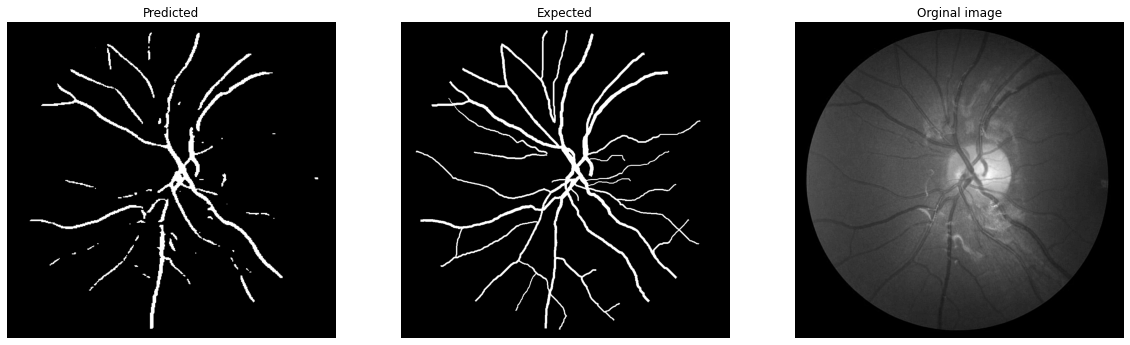

In [198]:
# u = DeepLearning()
# u.use_model("models/small_bs4/", "Unet_purple_background6.h5", "Image_13L.jpg")

In [196]:
# print(u.statistic())

32796 589954 8545 27815
(0.9448347013396853, 0.5410899011730544, 0.9857226160778881, 0.7303181176156245)
